In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
WITH_SERVICE_AUTHENTICATION = 'WITH_SERVICE_AUTHENTICATION'
WITH_CLIENT_AUTHENTICATION = 'WITH_CLIENT_AUTHENTICATION'
NO_SOMEIP_SD = 'NO_SOMEIP_SD'
WITH_DNSSEC = 'WITH_DNSSEC'
WITH_DANE = 'WITH_DANE'
WITH_ENCRYPTION = 'WITH_ENCRYPTION'

STATISTICS_PARENT_PATH='/home/mehmet/vscode-workspaces/mininet-vsomeip/statistic-results'

compile_definitions = {'A':'Vanilla',
                        'B':f'{NO_SOMEIP_SD} {WITH_DNSSEC}',
                        'C':f'{WITH_SERVICE_AUTHENTICATION}',
                        'D':f'{NO_SOMEIP_SD} {WITH_SERVICE_AUTHENTICATION} {WITH_DNSSEC} {WITH_DANE}',
                        'E':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION}',
                        'F':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION} {WITH_ENCRYPTION}',
                        'G':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION} {WITH_DNSSEC} {WITH_DANE}',
                        'H':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION} {WITH_DNSSEC} {WITH_DANE} {WITH_ENCRYPTION}'}

In [37]:
# fig, ax = plt.subplots(4, 2, figsize=(30, 20))
# row = 0
# column = 0
# for option, description in compile_definitions.items():
#     evaluation_option = option
#     member_count = 1
#     ax[row, column].set_title(f"{option}: {description}")
#     ax[row, column].set_ylabel('Duration [ms]')

#     file_count = 0
#     filename = f'{STATISTICS_PATH}/{evaluation_option}-{member_count}-#{file_count}.csv'
#     discovery_latency: list = list()
#     subscription_latency: list = list()
#     while Path(filename).is_file():
#         df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
#         if NO_SOMEIP_SD in description:
#             discovery_upper_bound = 'SVCB_SERVICE_RESPONSE_RECEIVE'
#         else:
#             discovery_upper_bound = 'OFFER_RECEIVE'
#         subscription_lower_bound = discovery_upper_bound
#         if WITH_SERVICE_AUTHENTICATION in description:
#             subscription_upper_bound = 'VERIFY_SERVICE_SIGNATURE_END'
#         else:
#             subscription_upper_bound = 'SUBSCRIBE_ACK_RECEIVE'
#         discovery_latency.append(df[discovery_upper_bound].max()/1000_000 - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000)
#         subscription_latency.append(df[subscription_upper_bound].max()/1000_000 - df[subscription_lower_bound].min()/1000_000)
#         file_count += 1
#         filename = f'{STATISTICS_PATH}/{evaluation_option}-{member_count}-#{file_count}.csv'
#     ax[row, column].boxplot([discovery_latency, subscription_latency])
#     ax[row, column].set_xticklabels(labels=['discovery_latency', 'subscription_latency'], rotation=0)
#     column += 1
#     if not (column % 2):
#         column = 0
#         row += 1
# plt.show()


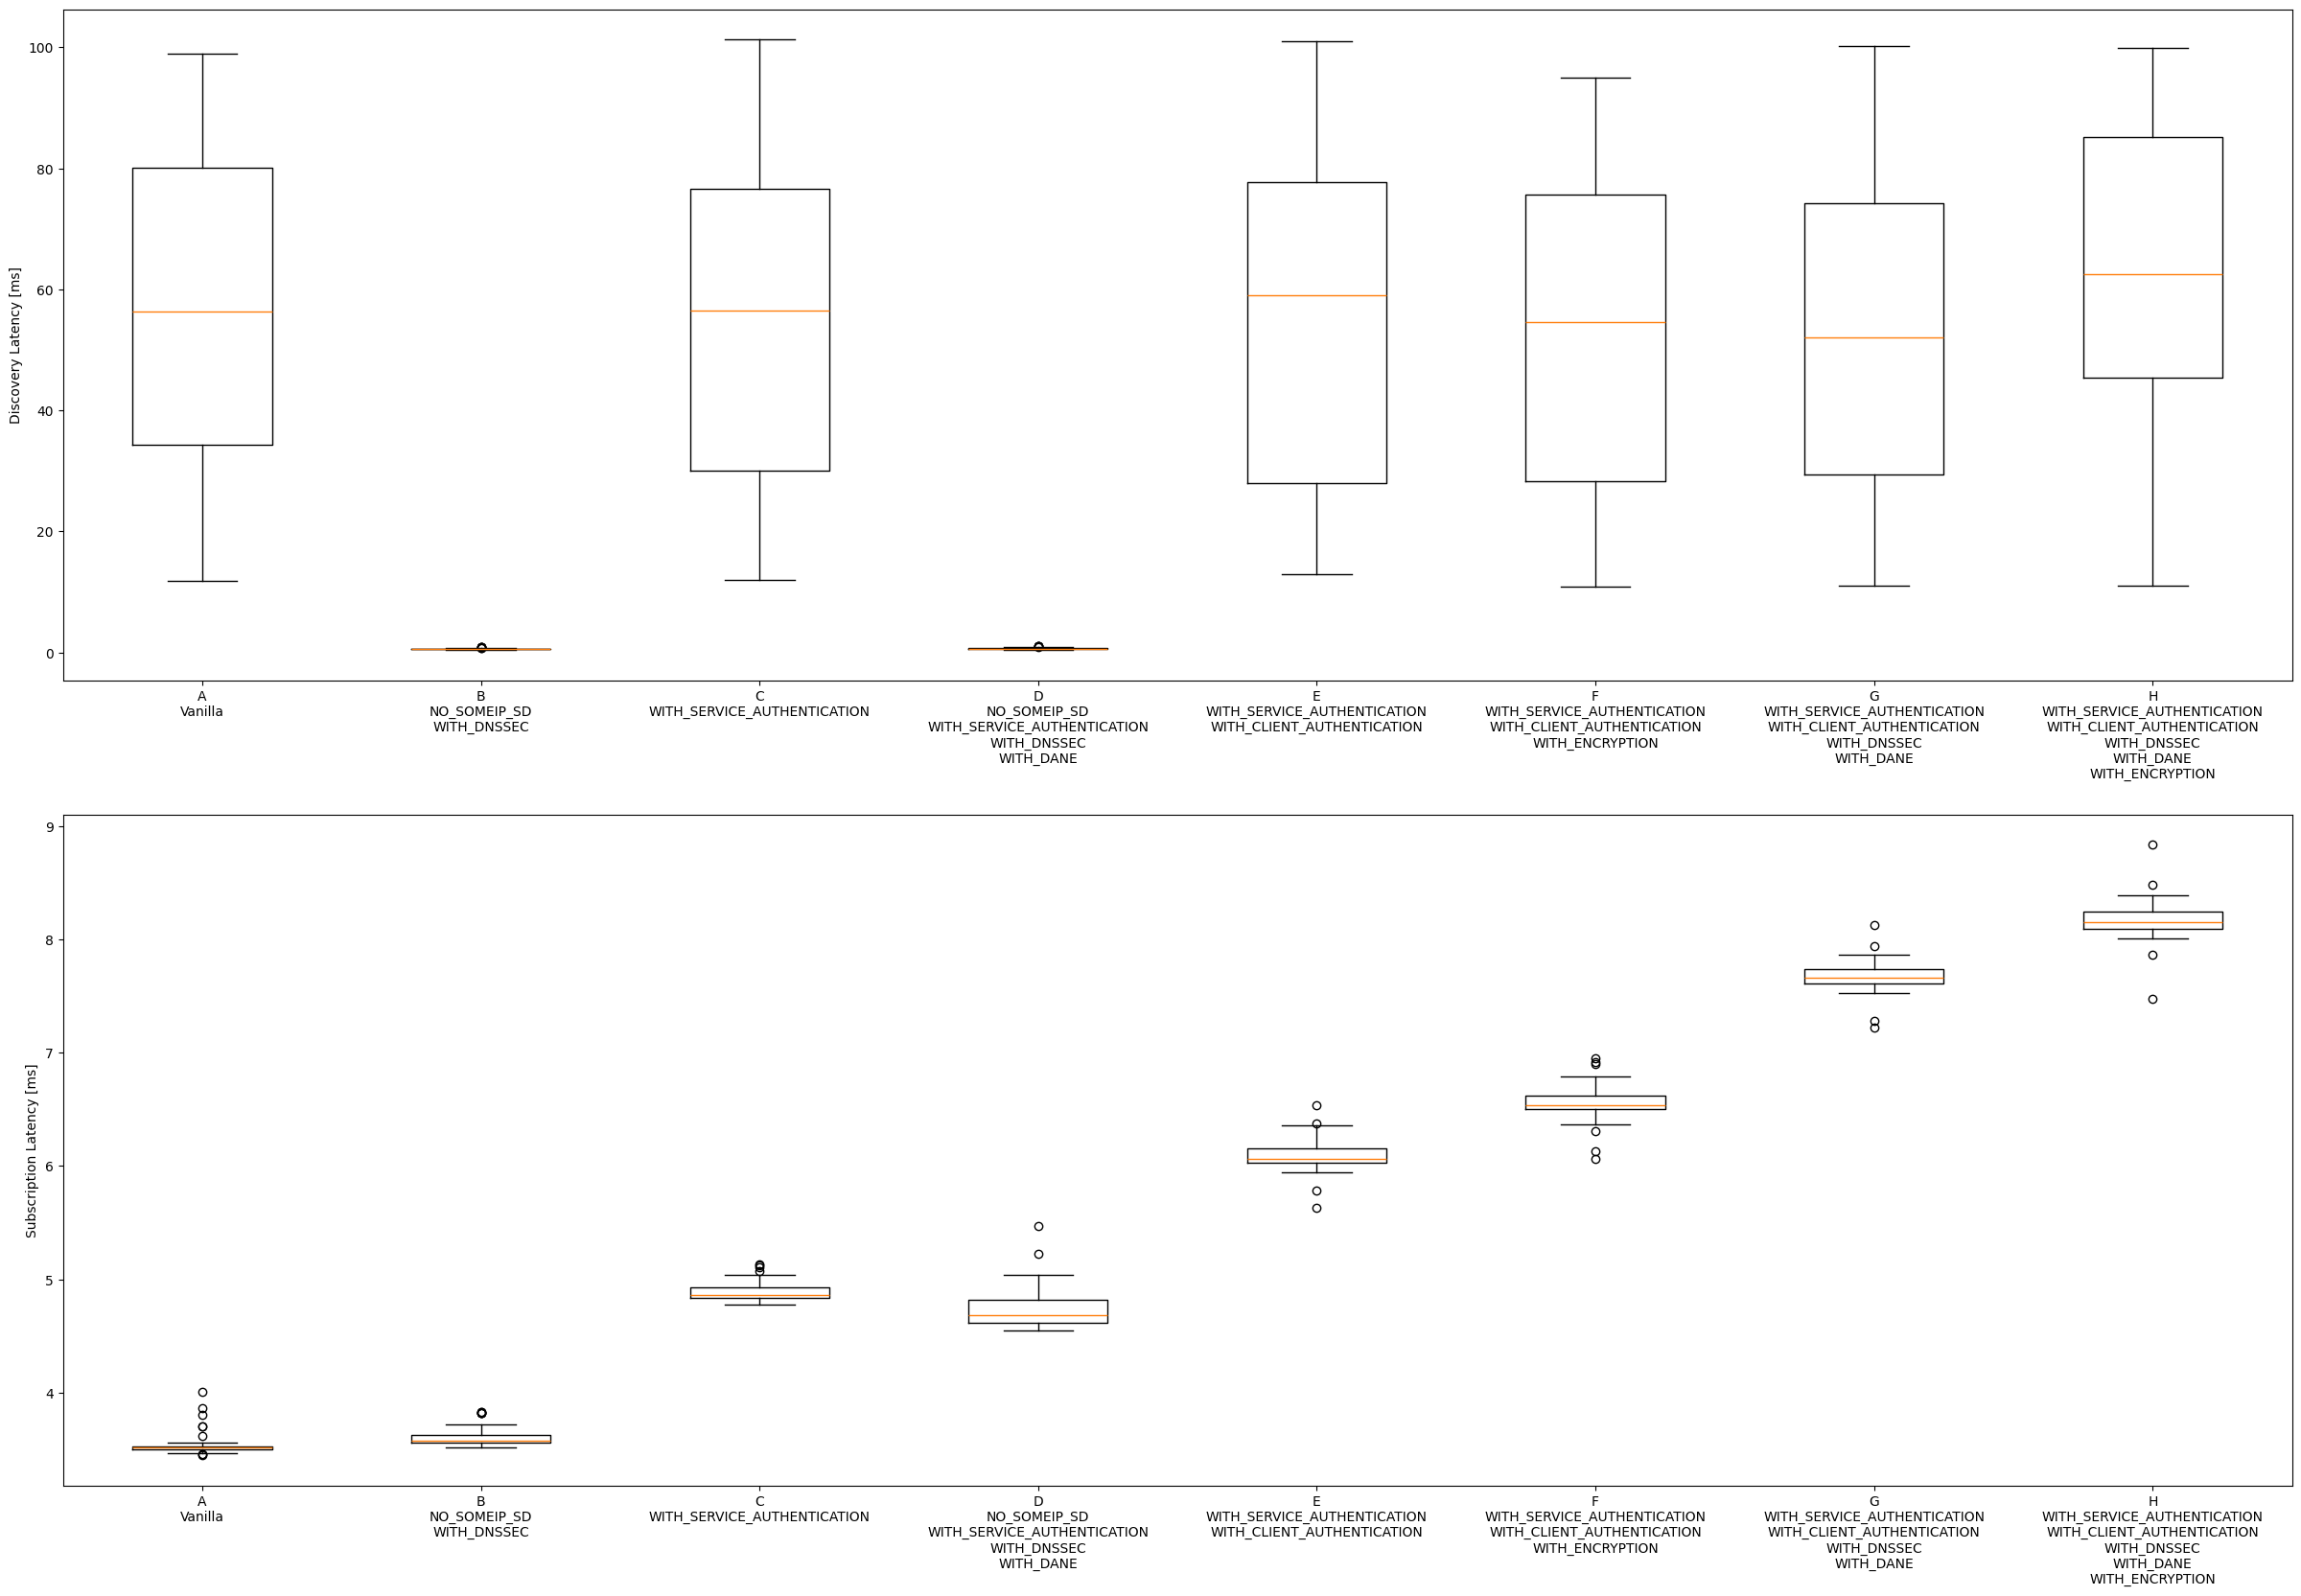

In [3]:
discovery_latency_dict: dict = dict()
subscription_latency_dict: dict = dict()
fig, ax = plt.subplots(2, 1, figsize=(30, 20))
title: str = ''

box_labels:list = list()


ax[0].set_ylabel('Discovery Latency [ms]')
ax[1].set_ylabel('Subscription Latency [ms]')

for option, description in compile_definitions.items():
    evaluation_option = option
    member_count = 1
    description_list = description.split()
    box_labels.append(option+'\n'+'\n'.join(description_list))

    file_count = 0
    filename = f'{STATISTICS_PARENT_PATH}/1xpublisher-1xsubscriber/{evaluation_option}-{member_count}-#{file_count}.csv'
    discovery_latency: list = list()
    subscription_latency: list = list()
    while Path(filename).is_file():
        df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
        if NO_SOMEIP_SD in description:
            discovery_upper_bound = 'SVCB_SERVICE_RESPONSE_RECEIVE'
        else:
            discovery_upper_bound = 'OFFER_RECEIVE'
        subscription_lower_bound = discovery_upper_bound
        if WITH_SERVICE_AUTHENTICATION in description:
            subscription_upper_bound = 'VERIFY_SERVICE_SIGNATURE_END'
        else:
            subscription_upper_bound = 'SUBSCRIBE_ACK_RECEIVE'
        discovery_latency.append(df[discovery_upper_bound].max()/1000_000 - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000)
        subscription_latency.append(df[subscription_upper_bound].max()/1000_000 - df[subscription_lower_bound].min()/1000_000)
        file_count += 1
        filename = f'{STATISTICS_PARENT_PATH}/1xpublisher-1xsubscriber/{evaluation_option}-{member_count}-#{file_count}.csv'
    discovery_latency_dict[option] = discovery_latency
    subscription_latency_dict[option] = subscription_latency
ax[0].boxplot(discovery_latency_dict.values())
ax[0].set_xticklabels(labels=box_labels, rotation=0)
ax[1].boxplot(subscription_latency_dict.values())
ax[1].set_xticklabels(labels=box_labels, rotation=0)
# plt.subplots_adjust(hspace=0.4)
plt.show()

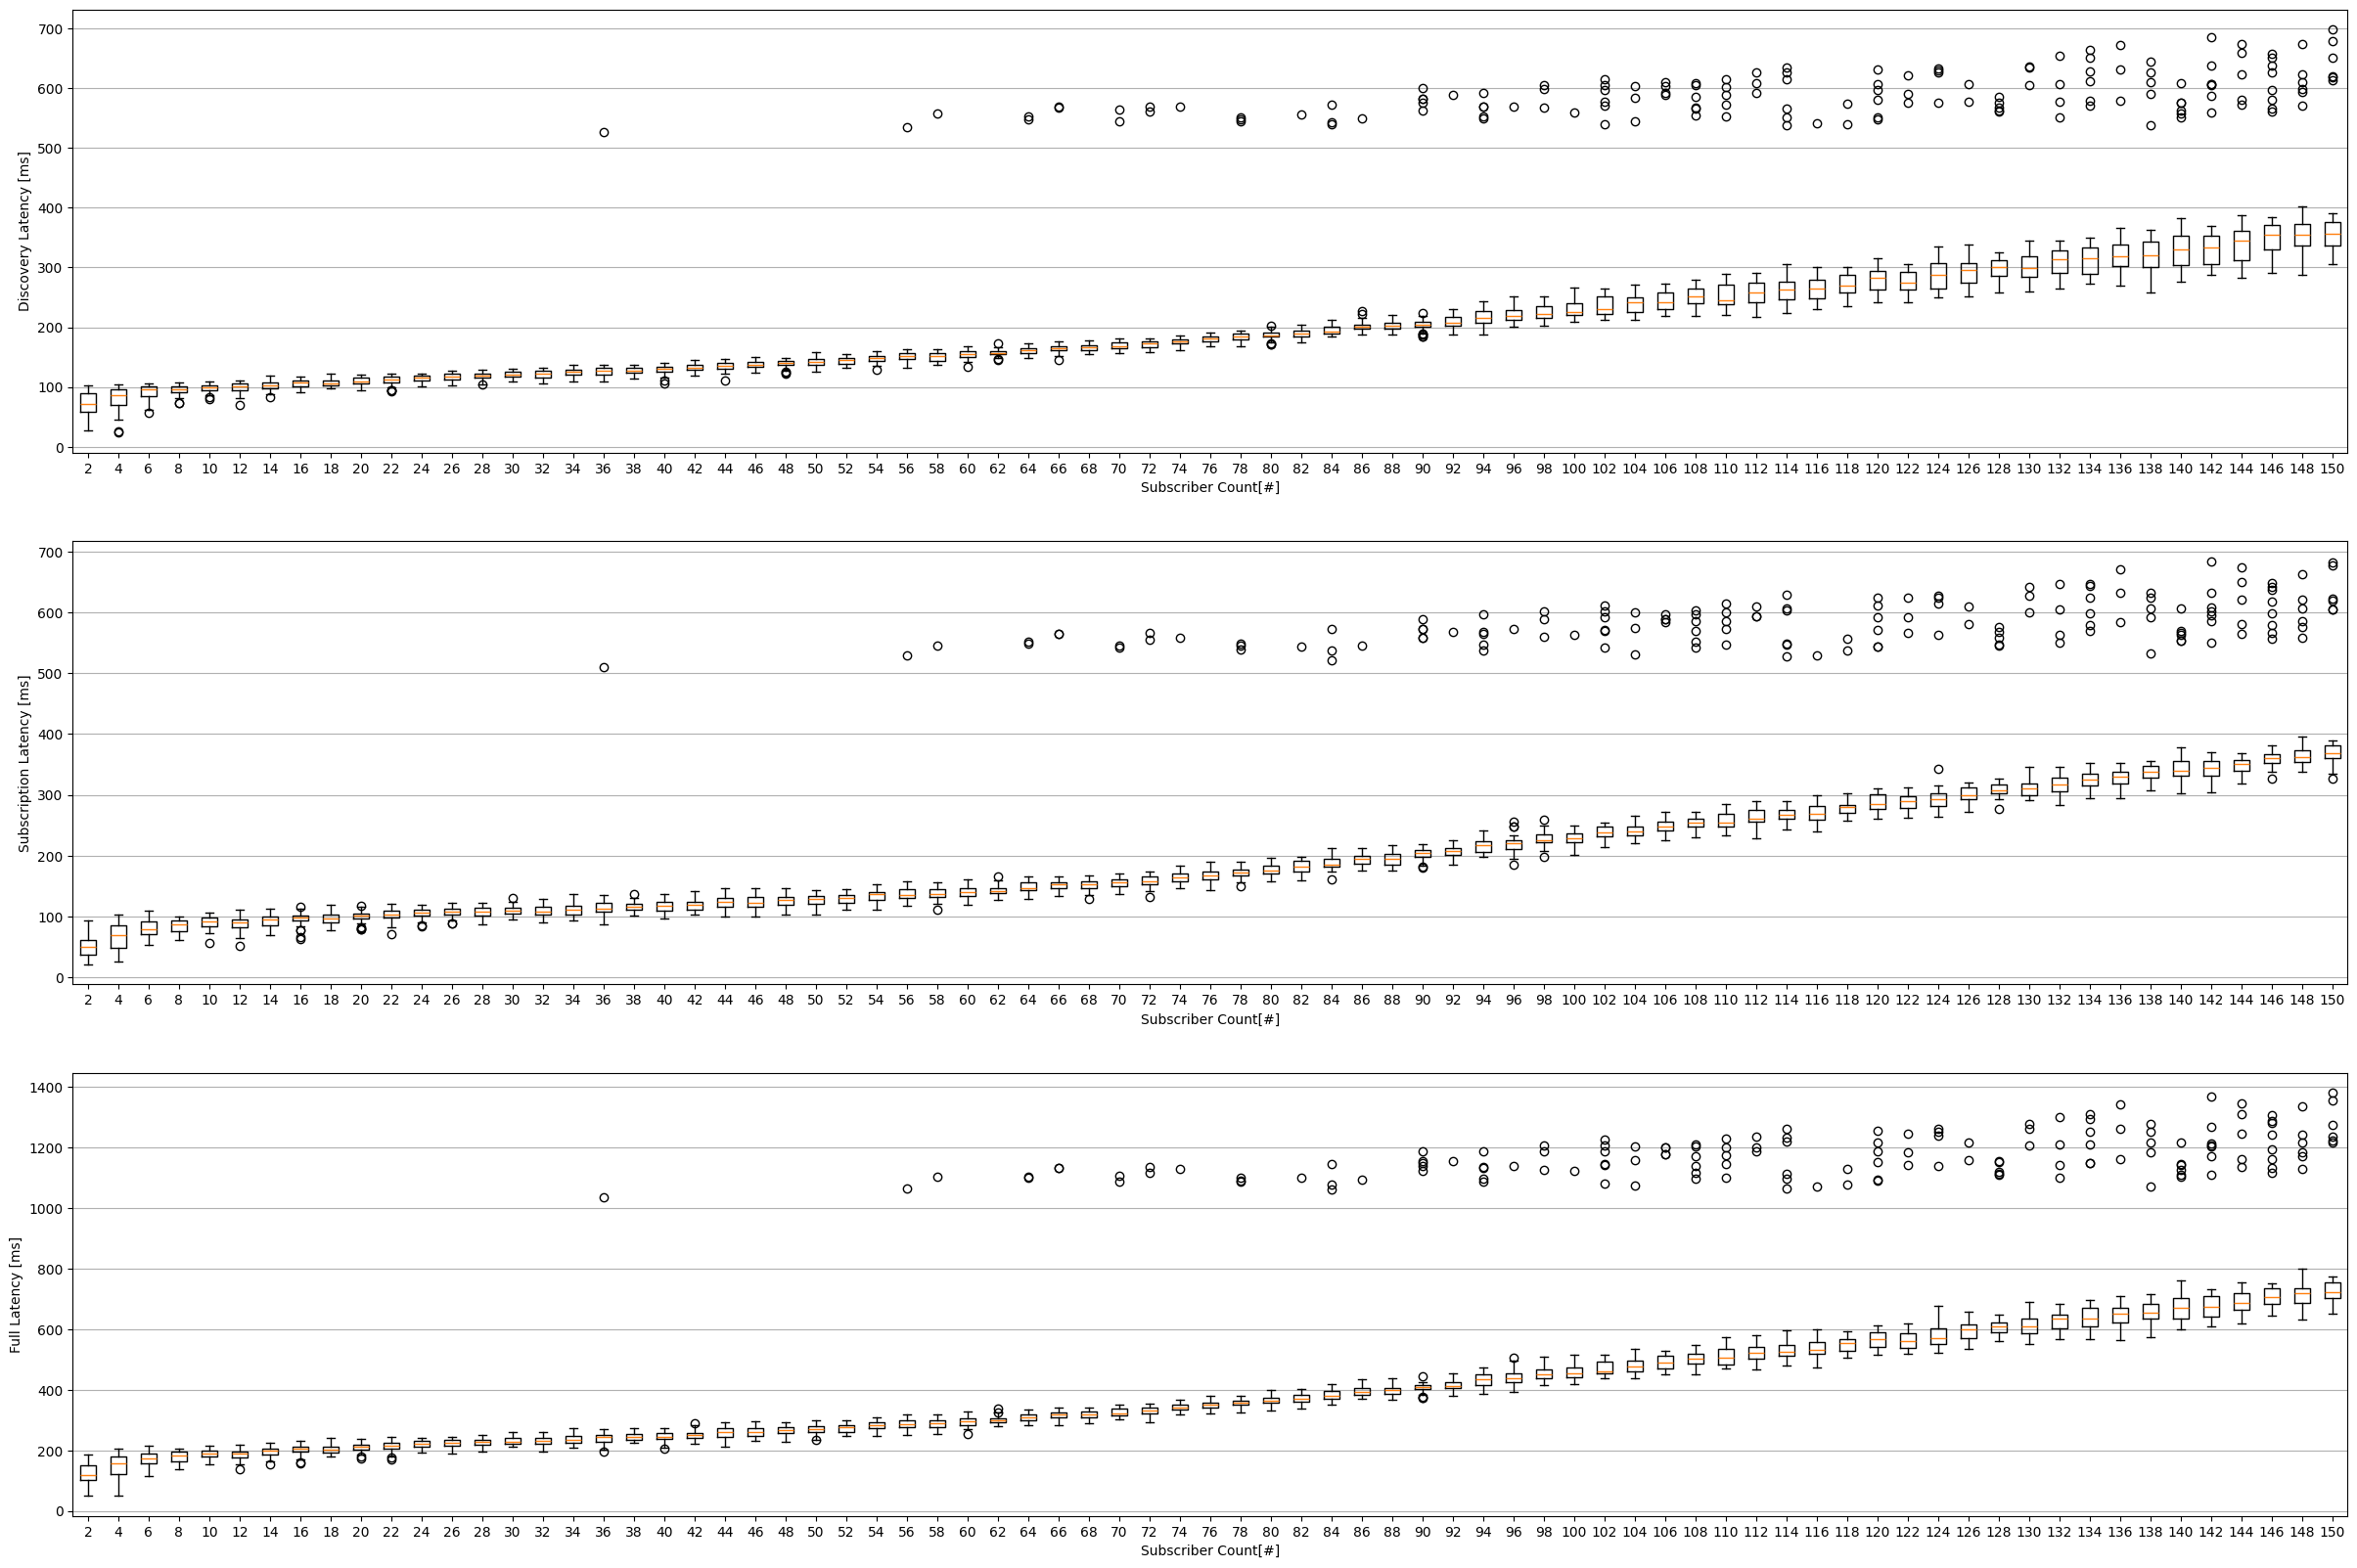

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(30, 20))
ax[0].set_ylabel('Discovery Latency [ms]')
ax[1].set_ylabel('Subscription Latency [ms]')
ax[2].set_ylabel('Full Latency [ms]')

option = 'H'
description = compile_definitions[option]

discovery_latency_dict: dict = dict()
subscription_latency_dict: dict = dict()
full_latency_dict: dict = dict()
member_count_axis: list = list()
for member_count in range(0,151,2):
    if member_count == 0:
        continue
    member_count_axis.append(member_count)
    discovery_latency: list = list()
    subscription_latency: list = list()
    full_latency: list = list()
    for file_count in range(0,50):
        filename = f'{STATISTICS_PARENT_PATH}/{option}-series/{option}-{member_count}-#{file_count}.csv'
        df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
        if NO_SOMEIP_SD in description:
            discovery_upper_bound = df['SVCB_SERVICE_RESPONSE_RECEIVE'].max()/1000_000
            subscription_lower_bound = df['SVCB_SERVICE_RESPONSE_RECEIVE'].min()/1000_000
        else:
            discovery_upper_bound = df['OFFER_RECEIVE'].max()/1000_000
            subscription_lower_bound = df['OFFER_RECEIVE'].min()/1000_000
        if WITH_SERVICE_AUTHENTICATION in description:
            subscription_upper_bound = df['VERIFY_SERVICE_SIGNATURE_END'].max()/1000_000
        else:
            subscription_upper_bound = df['SUBSCRIBE_ACK_RECEIVE'].max()/1000_000
        discovery_latency.append(discovery_upper_bound - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000)
        subscription_latency.append(subscription_upper_bound - subscription_lower_bound)
        full_latency.append((discovery_upper_bound - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000) + (subscription_upper_bound - subscription_lower_bound))
    discovery_latency_dict[member_count] = discovery_latency
    subscription_latency_dict[member_count] = subscription_latency
    full_latency_dict[member_count] = full_latency
    df_discovery_latency = pd.DataFrame()
    df_subscription_latency = pd.DataFrame()
    df_full_latency = pd.DataFrame()
    df_discovery_latency['DISCOVERY_LATENCY'] = discovery_latency
    df_subscription_latency['SUBSCRIPTION_LATENCY'] = subscription_latency
    df_full_latency['FULL_LATENCY'] = full_latency
    df_discovery_latency.to_csv(f'export/{option}-{member_count}-DISCOVERY-LATENCY.csv', index=False)
    df_subscription_latency.to_csv(f'export/{option}-{member_count}-SUBSCRIPTION-LATENCY.csv', index=False)
    df_full_latency.to_csv(f'export/{option}-{member_count}-FULL-LATENCY.csv', index=False)

ax[0].boxplot(discovery_latency_dict.values())
ax[0].set_xticklabels(labels=member_count_axis, rotation=0)
ax[0].set_xlabel("Subscriber Count[#]")
ax[0].yaxis.grid(True)

ax[1].boxplot(subscription_latency_dict.values())
ax[1].set_xticklabels(labels=member_count_axis, rotation=0)
ax[1].set_xlabel("Subscriber Count[#]")
ax[1].yaxis.grid(True)

ax[2].boxplot(full_latency_dict.values())
ax[2].set_xticklabels(labels=member_count_axis, rotation=0)
ax[2].set_xlabel("Subscriber Count[#]")
ax[2].yaxis.grid(True)
plt.show()

In [49]:
import statistics

option = 'G'
member_count = 150
file_count = 0
filename = f'{STATISTICS_PARENT_PATH}/{option}-series/{option}-{member_count}-#{file_count}.csv'
df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
print(df['SUBSCRIBER_APP_INITIALIZATION_END'].min())
print(df['VERIFY_SERVICE_SIGNATURE_END'].max())
df['FULL_LATENCY'] = df['VERIFY_SERVICE_SIGNATURE_END'] - df['SUBSCRIBER_APP_INITIALIZATION_END']
print(df['FULL_LATENCY'].min())
print(df['FULL_LATENCY'].max())

1707512220363008176
1707512220731115207
26989732
228560960


In [11]:
option = 'G'
found_rows_list: list = list()
for member_count in range(1,151):
    for file_count in range(0,50):
        filename = f'{STATISTICS_PARENT_PATH}/{option}-series/{option}-{member_count}-#{file_count}.csv'
        df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
        found_rows = len(df[df['SVCB_SERVICE_RESPONSE_RECEIVE'] > df['OFFER_RECEIVE']])
        if found_rows:
            found_rows_list.append(found_rows)
            #print(f'found in {option}-{member_count}-#{file_count}.csv')
print(f'Maximum rows in one file {max(found_rows_list)}')
print(len(found_rows_list))
print(found_rows_list)

Maximum rows in one file 4
133
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 2]


In [9]:
option = 'G'
member_count = 33
file_count = 37
filename = f'{STATISTICS_PARENT_PATH}/{option}-series/{option}-{member_count}-#{file_count}.csv'
df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
df[df['SVCB_SERVICE_RESPONSE_RECEIVE'] > df['OFFER_RECEIVE']]

,HOST,PUBLISHER_APP_INITIALIZATION,SUBSCRIBER_APP_INITIALIZATION_START,SUBSCRIBER_APP_INITIALIZATION_END,GENERATE_OFFER_NONCE_START,GENERATE_OFFER_NONCE_END,FIND_SEND,FIND_RECEIVE,OFFER_SEND,OFFER_RECEIVE,...,SERVICE_SIGN_START,SERVICE_SIGN_END,SUBSCRIBE_ACK_SEND,SUBSCRIBE_ACK_RECEIVE,TLSA_SERVICE_REQUEST_SEND,TLSA_SERVICE_REQUEST_RECEIVE,TLSA_SERVICE_RESPONSE_SEND,TLSA_SERVICE_RESPONSE_RECEIVE,VERIFY_SERVICE_SIGNATURE_START,VERIFY_SERVICE_SIGNATURE_END
22,167772184,0,1707523319883597173,1707523319884707897,0,0,1707523319899612510,0,0,1707523319901074723,...,1707523319912618082,1707523319913392676,1707523319913393580,1707523319913595741,1707523319904957529,0,0,1707523319907998673,1707523319909105163,1707523319913859386
